In [1]:
import sys
sys.path.append('/global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/')

%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np
import numpy as onp
import os

import numpyro
import numpyro.distributions as dist

print("JAX version:", jax.__version__)
#print("jax-cosmo version:", jc.__version__)
print("Using Modified Jax-cosmo from: ", jc.__file__)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
JAX version: 0.4.13
Using Modified Jax-cosmo from:  /global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/jax_cosmo/__init__.py


In [2]:
# Create a cosmology with default parameters
cosmo_P15 = jc.Planck15()

In [3]:
# Now let's try to build the equivalent with jax-cosmo

# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
testing a and z 513 [0.09090909 0.09268466 0.09446023 0.0962358  0.09801137 0.09978694
 0.1015625  0.10333807 0.10511364 0.10688921 0.10866477 0.11044034
 0.11221591 0.11399148 0.11576705 0.11754262 0.11931819 0.12109375
 0.12286932 0.12464489 0.12642047 0.12819603 0.1299716  0.13174716
 0.13352272 0.1352983  0.13707387 0.13884944 0.140625   0.14240056
 0.14417614 0.14595172 0.14772728 0.14950284 0.1512784  0.15305397
 0.15482955 0.15660512 0.15838069 0.16015625 0.16193181 0.16370739
 0.16548297 0.16725853 0.1690341  0.17080966 0.17258522 0.1743608
 0.17613637 0.17791194 0.1796875  0.18146306 0.18323864 0.18501422
 0.18678978 0.18856534 0.1903409  0.19211647 0.19389205 0.19566762
 0.19744319 0.19921875 0.20099431 0.20276989 0.20454545 0.20632103
 0.2080966  0.20987216 0.21164772 0.2134233  0.21519887 0.21697444
 0.21875    0.22052556 0.22230114 0.2240767  0.22585228 0.22762784
 0.2294034  0.23117897 0.23295455 0.23473012 0.23650569 0.23828125
 0.240056

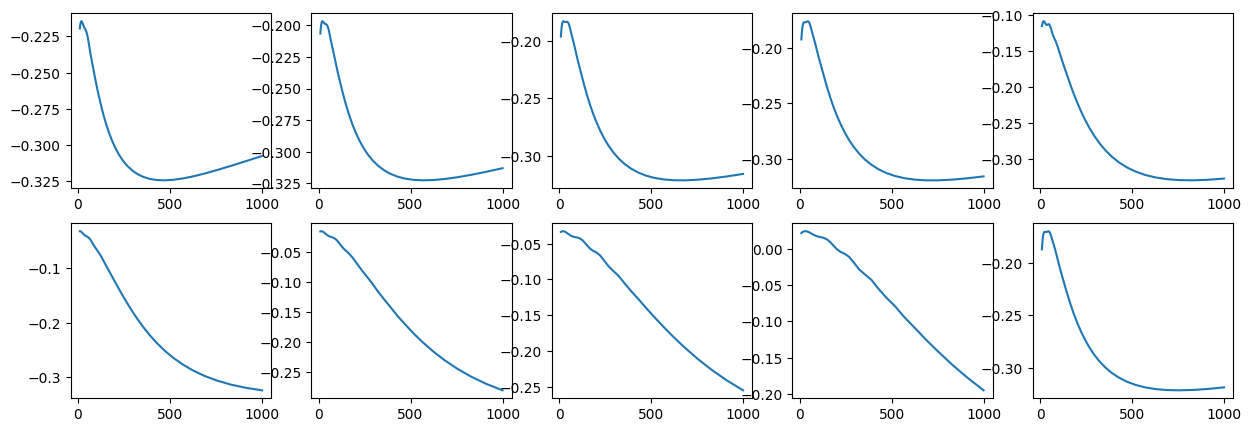

In [5]:
# Create one with late-time modification (bin); keep others the same as planck15
from jax_cosmo.core import Cosmology

_z_bin = onp.array([0.0,   1.0, 5])
_k_bin = onp.array([0.025, 0.8, 5])
# _k_bin = onp.array([-2, 0, 5]) 

tmpa = np.array([0. for i in range(int(_z_bin[2]))])
print(tmpa)
tmpb = np.array([0. for i in range(int(_k_bin[2]))])
print(tmpb)

cosmo_modified2 = Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1.0, # Fix w0=-1
                          Omega_k=0., wa=0.,
                         a_late=[-0.2, 0., 0., 0., 0.1], z_mod_form="bin_custom", z_bin=_z_bin,
                         b_late=tmpb, k_mod_form="bin_custom", k_bin=_k_bin)

# You can inspect the documentation to see the 
# meaning of these positional arguments


dz =  [0.0,0.0,0.0,0.0]
A = 0.5
eta = 0.0
bias = [1.2, 1.4, 1.6, 1.8, 2.0]
m = [0.0,0.0,0.0,0.0]


nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
            for nzi, dzi in zip(nzs_s, dz)]

# Define IA model, z0 is fixed
b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
# Bias for the lenses
b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

# Define the lensing and number counts probe
probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                ia_bias=b_ia,
                                multiplicative_bias=m),
         jc.probes.NumberCounts(nzs_l, b)]

ell = np.logspace(1,3) # Defines a range of \ell

# And compute the data vector
cls_P15 = jc.angular_cl.angular_cl(cosmo_P15, ell, probes)


# Cls for modified cosmology
cls_modified2 = jc.angular_cl.angular_cl(cosmo_modified2, ell, probes)


residue2 = (cls_modified2 - cls_P15) / cls_P15

fig, axes = plt.subplots(2, 5, figsize=(15, 5))

for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, residue2[i*5 + j])

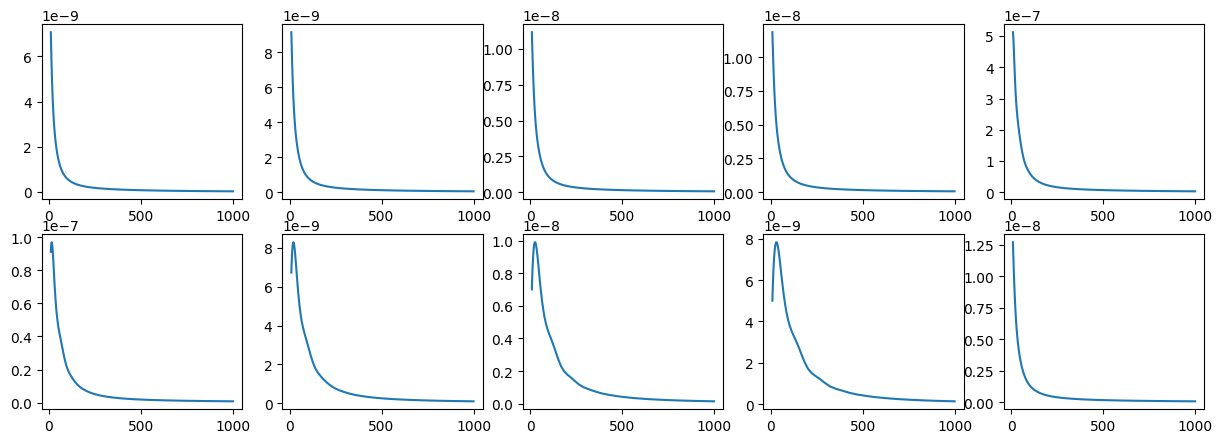

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, cls_modified2[i*5 + j])

In [7]:
cls_modified2[0]

Array([7.06684800e-09, 6.67807321e-09, 6.27696162e-09, 5.86939430e-09,
       5.46147483e-09, 5.05768938e-09, 4.66289052e-09, 4.28043068e-09,
       3.91359389e-09, 3.56475538e-09, 3.23582872e-09, 2.92758329e-09,
       2.64028865e-09, 2.37383979e-09, 2.12785833e-09, 1.90142257e-09,
       1.69333336e-09, 1.50264046e-09, 1.32874878e-09, 1.17139165e-09,
       1.03066944e-09, 9.06554665e-10, 7.97833521e-10, 7.02486347e-10,
       6.18847695e-10, 5.45775203e-10, 4.82083096e-10, 4.26295860e-10,
       3.77400639e-10, 3.34799022e-10, 2.97642688e-10, 2.65099914e-10,
       2.36488995e-10, 2.11318296e-10, 1.89076838e-10, 1.69338585e-10,
       1.51760104e-10, 1.36042816e-10, 1.21935018e-10, 1.09232984e-10,
       9.77611048e-11, 8.73771333e-11, 7.79639478e-11, 6.94224747e-11,
       6.16699539e-11, 5.46374057e-11, 4.82651107e-11, 4.25012456e-11,
       3.72998646e-11, 3.26193100e-11], dtype=float32)